In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
import yfinance
import warnings
warnings.filterwarnings('ignore')


data = pd.read_csv('data\df.csv',sep='|')
data['date'] = pd.to_datetime(data['date'])

DXY = yfinance.download('DX-Y.NYB', start='1999-01-04', end='2025-09-19')
DXY = DXY.reset_index()[['Date','Close']]
DXY.columns = ['date','DXY']
data=data.merge(DXY, on='date', how='left')

GDPM = pd.read_csv('GDP Monthly.csv',sep=',')
GDPM['date'] = pd.to_datetime(GDPM['timestamp'])
GDPM['year'] = GDPM['date'].dt.year
GDPM['month'] = GDPM['date'].dt.month
GDPM['CroissM'] = GDPM['EIA/GDPQXUS/USA'].diff()

data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

data = data.merge(GDPM, on=['year', 'month'], how='left')
data.drop(['timestamp','date_y','year','month'], axis=1, inplace=True)
data['DXY'].fillna(method='ffill', inplace=True)
data.set_index('date_x', inplace=True)
print(data.columns)

<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
C:\Users\HOME\AppData\Local\Temp\ipykernel_8600\2942552193.py:14: SyntaxWarning: invalid escape sequence '\d'
  data = pd.read_csv('data\df.csv',sep='|')
[*********************100%***********************]  1 of 1 completed

Index(['close', 'volume', 'high', 'low', 'pe', 'num_daily_adv_minus_decl',
       'mov_avg_20d', 'best_eps', 'dvd_sh_last', 'rsi_3d', 'rsi_9d', 'rsi_14d',
       'rsi_30d', 'mov_avg_10d', 'mov_avg_30d', 'mov_avg_50d', 'pb', 'pib_pct',
       'pib', 'vix', 'i', 'i_future', 'inflation', 'gold', 'gold_pct',
       'gold_volume', 'brent', 'brent_pct', 'brent_volume', 'cible', 'returns',
       'vol', 'score', 'momentum_10d', 'macd', 'macd_signal', 'bb_upper',
       'bb_lower', 'mov_avg_100d', 'mov_avg_200d', 'mov_avg_10_50_diff',
       'mov_avg_20_50_diff', 'close_minus_10d', 'close_minus_20d',
       'close_minus_30d', 'close_minus_50d', 'close_minus_100d',
       'close_minus_200d', 'DXY', 'EIA/GDPQXUS/USA', 'CroissM'],
      dtype='object')


Création des features temporelles (lookback: 10 jours)...
Features créées. Nouvelles dimensions: (6719, 502)
Target: Prix du S&P 500 dans 5 jour(s)
Dataset CART préparé:
  - Observations: 6689
  - Features: 289
  - Type de prédiction: regression

 ENTRAÎNEMENT SUR PÉRIODE PERSONNALISÉE
   Début: 2010-01-01
   Fin:   2025-11-08
   Observations: 3947
Modèle CART regression ajusté.
Profondeur réelle de l'arbre: 15
Nombre de feuilles: 221
=== TOP 20 FEATURES IMPORTANTES ===
              feature  importance
          close_lag_1    0.794042
    mov_avg_30d_lag_2    0.108926
          mov_avg_20d    0.066156
    mov_avg_50d_lag_5    0.014060
          mov_avg_10d    0.011792
         mov_avg_200d    0.001867
      EIA/GDPQXUS/USA    0.000840
    mov_avg_50d_lag_1    0.000727
          close_lag_2    0.000173
   mov_avg_200d_lag_5    0.000123
    gold_volume_lag_5    0.000090
            DXY_lag_5    0.000078
                 high    0.000072
EIA/GDPQXUS/USA_lag_5    0.000065
   mov_avg_100d

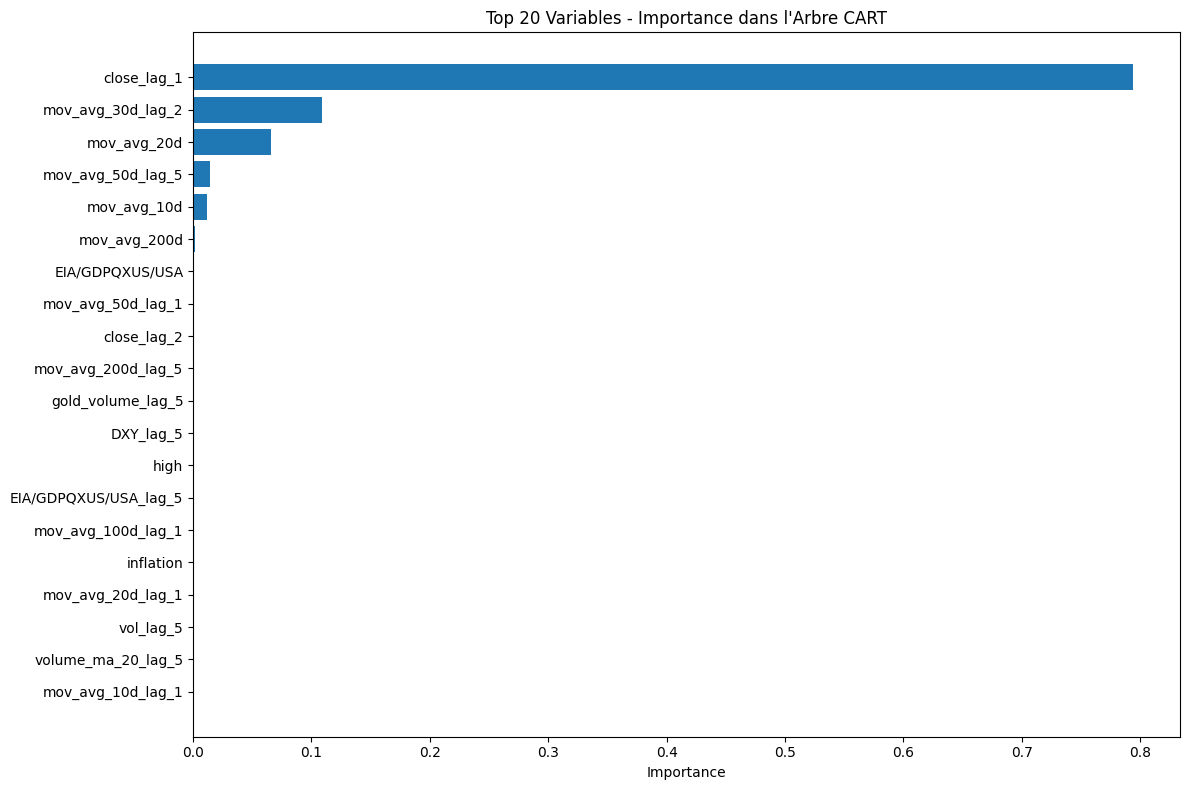

=== VALIDATION SUR 1338 OBSERVATIONS ===
MAE: 56.36
RMSE: 76.52
MAPE: 1.25%


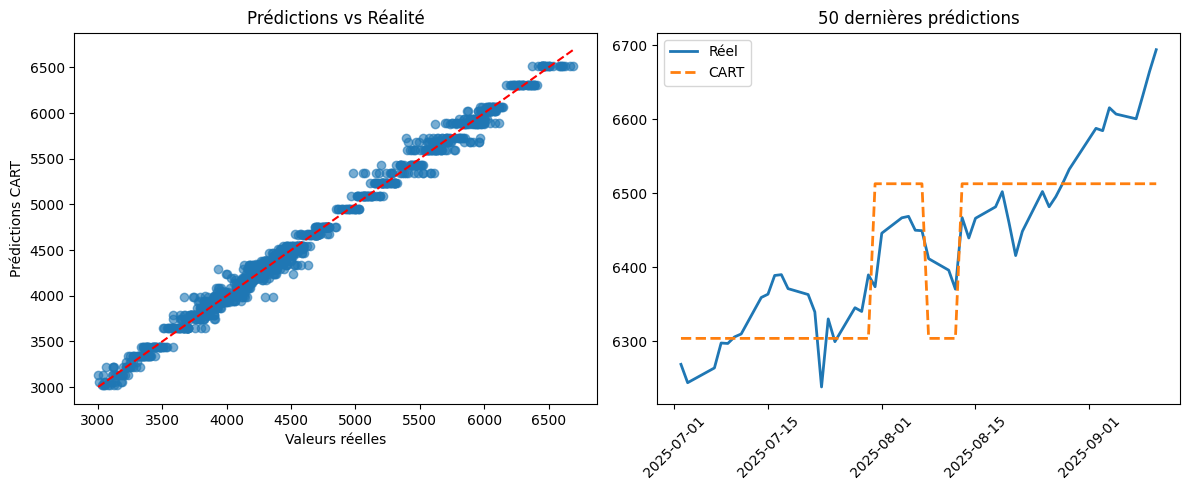

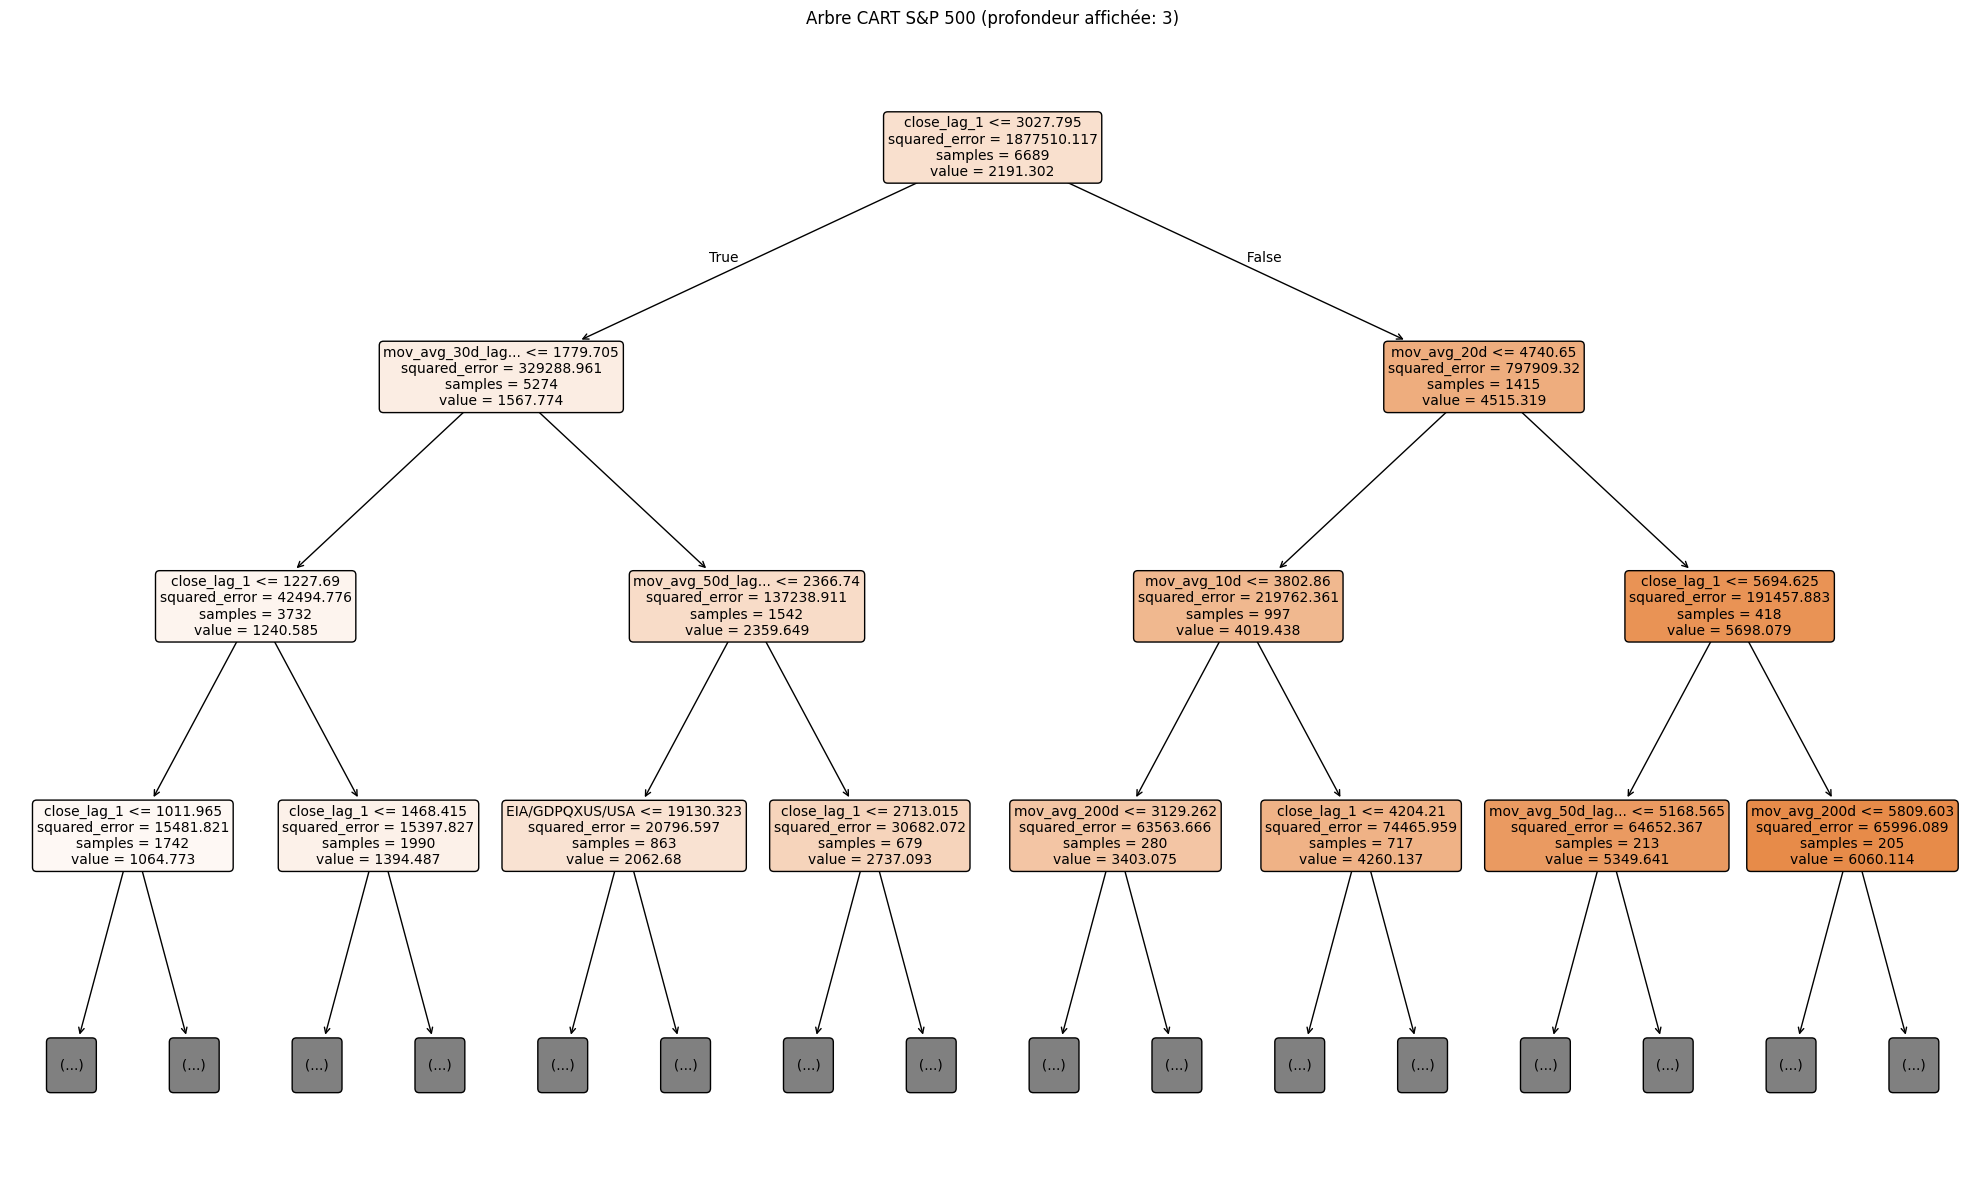


=== RÈGLES DE L'ARBRE (profondeur 3) ===
|--- close_lag_1 <= 3027.80
|   |--- mov_avg_30d_lag_2 <= 1779.71
|   |   |--- close_lag_1 <= 1227.69
|   |   |   |--- close_lag_1 <= 1011.96
|   |   |   |   |--- truncated branch of depth 9
|   |   |   |--- close_lag_1 >  1011.96
|   |   |   |   |--- truncated branch of depth 10
|   |   |--- close_lag_1 >  1227.69
|   |   |   |--- close_lag_1 <= 1468.41
|   |   |   |   |--- truncated branch of depth 12
|   |   |   |--- close_lag_1 >  1468.41
|   |   |   |   |--- truncated branch of depth 8
|   |--- mov_avg_30d_lag_2 >  1779.71
|   |   |--- mov_avg_50d_lag_5 <= 2366.74
|   |   |   |--- EIA/GDPQXUS/USA <= 19130.32
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- EIA/GDPQXUS/USA >  19130.32
|   |   |   |   |--- truncated branch of depth 4
|   |   |--- mov_avg_50d_lag_5 >  2366.74
|   |   |   |--- close_lag_1 <= 2713.02
|   |   |   |   |--- truncated branch of depth 6
|   |   |   |--- close_lag_1 >  2713.02
|   |   |   |   |--- tr

In [25]:
# Algorithme CART

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.tree import plot_tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

class SP500CARTForecaster:
    """
    Modèle CART pour prédiction du S&P 500 avec données temporelles
    """
    
    def __init__(self, prediction_type='regression'):
        """
        Parameters:
        -----------
        prediction_type : str
            'regression' pour prédire le prix
            'classification' pour prédire la direction (hausse/baisse)
        """
        self.prediction_type = prediction_type
        self.model = None
        self.data = None
        self.features = None
        self.target = None
        self.feature_names = []
        self.is_fitted = False
        
    def load_data(self, file_path):
        """
        Charge les données depuis le fichier Excel
        """
        try:
            df = data
            print(f"Fichier chargé: {df.shape[0]} lignes, {df.shape[1]} colonnes")
            print(f"Colonnes disponibles: {list(df.columns)}")
            
            # Détecter la colonne de date
            date_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
            if date_cols:
                df[date_cols[0]] = pd.to_datetime(df[date_cols[0]])
                df.set_index(date_cols[0], inplace=True)
                print(f"Colonne de date détectée: {date_cols[0]}")
            
            self.data = df
            return df
            
        except Exception as e:
            print(f"Erreur lors du chargement: {e}")
            return None
    
    def create_time_series_features(self, target_column='cible', lookback_periods=20):
        """
        Crée des features temporelles adaptées aux arbres de décision
        
        Parameters:
        -----------
        target_column : str
            Colonne cible (prix S&P 500)
        lookback_periods : int
            Nombre de périodes passées à utiliser comme features
        """
        if self.data is None:
            raise ValueError("Données non chargées.")
            
        df = self.data.copy()
        
        print(f"Création des features temporelles (lookback: {lookback_periods} jours)...")
        
        # === 1. FEATURES DE PRIX HISTORIQUES (LAG FEATURES) ===
        
        for i in range(1, lookback_periods + 1):
             df[f'close_lag_{i}'] = df[target_column].shift(i)
           
        # === 2. FEATURES DE RENDEMENTS ===
        
        df['return_1d'] = df[target_column].pct_change()
        for i in range(2, 11):  # Rendements sur 2 à 10 jours
            df[f'return_{i}d'] = df[target_column].pct_change(periods=i)

        if target_column in df.columns:
            df['returns'] = df[target_column].pct_change()
            df['log_returns'] = np.log(df[target_column] / df[target_column].shift(1))
            
            # Volatilité réalisée (rolling)
            df['volatility_5d'] = df['returns'].rolling(5).std()
            df['volatility_20d'] = df['returns'].rolling(20).std()
            
        # Rendements cumulés
        for window in [5, 10, 20]:
            df[f'cumret_{window}d'] = df['return_1d'].rolling(window).sum()
            
        # === 3. FEATURES DE VOLATILITÉ ===
        
        for window in [5, 10, 20]:
            df[f'volatility_{window}d'] = df['return_1d'].rolling(window).std()
            df[f'vol_ratio_{window}d'] = df[f'volatility_{window}d'] / df['volatility_20d']
        
        # === 4. FEATURES TECHNIQUES ===
        
        if all(col in df.columns for col in ['Open', 'High', 'Low', 'close']):
            # Range et gaps
            df['daily_range'] = (df['High'] - df['Low']) / df['close']
            df['gap'] = (df['Open'] - df['close'].shift(1)) / df['close'].shift(1)
            df['body'] = (df['close'] - df['Open']) / df['close']
            
            # Patterns de chandelles (simplifiés)
            df['green_candle'] = (df['close'] > df['Open']).astype(int)
            df['big_move'] = (np.abs(df['return_1d']) > 0.02).astype(int)
            df['gap_up'] = (df['gap'] > 0.005).astype(int)
            df['gap_down'] = (df['gap'] < -0.005).astype(int)
        
        # RSI (approximatif)
        delta = df[target_column].diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))
        df['rsi_overbought'] = (df['rsi'] > 70).astype(int)
        df['rsi_oversold'] = (df['rsi'] < 30).astype(int)
        
        # === 6. FEATURES DE VOLUME (si disponible) ===
        
        if 'volume' in df.columns:
            df['volume_ma_20'] = df['volume'].rolling(20).mean()
            df['volume_ratio'] = df['volume'] / df['volume_ma_20']
            df['high_volume'] = (df['volume_ratio'] > 1.5).astype(int)
            df['low_volume'] = (df['volume_ratio'] < 0.5).astype(int)
        
        # === 7. FEATURES D'AUTRES VARIABLES (VIX, etc.) ===
        
        for col in df.columns:
            if col not in [target_column, 'Open', 'high', 'low', 'close', 'volume'] and df[col].dtype in ['float64', 'int64']:
                # Lags des autres variables
                for lag in [1, 2, 5]:
                    df[f'{col}_lag_{lag}'] = df[col].shift(lag)
                
                # Changements
                df[f'{col}_change'] = df[col].diff()
                df[f'{col}_pct_change'] = df[col].pct_change()
        
        # === 8. FEATURES COMBINÉES ===
        
        # Momentum combinations
        df['price_momentum'] = (df['return_1d'] > 0).astype(int) + (df['return_5d'] > 0).astype(int)
        df['vol_momentum'] = (df['volatility_5d'] > df['volatility_20d']).astype(int)
        
        # Regime features
        # df['ma_signal_short'] = (df[target_column] > df['mov_avg_10d']).astype(int)
        # df['ma_signal_long'] = (df[target_column] > df['mov_avg_30d']).astype(int)
        
        # df['price_vs_ma_10d'] = (df[target_column] - df['mov_avg_10d']) / df['mov_avg_10d']
        # df['price_vs_ma_20d'] = (df[target_column] - df['mov_avg_20d']) / df['mov_avg_20d']

        self.data = df
        print(f"Features créées. Nouvelles dimensions: {df.shape}")
        
        return df

        
    def prepare_cart_data(self, target_column='close', forecast_horizon=1):
        """
        Prépare les données pour CART (X, y)
        
        Parameters:
        -----------
        target_column : str
            Variable à prédire
        forecast_horizon : int
            Nombre de jours à l'avance à prédire
        """
        if self.data is None:
            raise ValueError("Données non préparées.")
            
        # Créer la variable cible
        if self.prediction_type == 'regression':
            # Prédire le prix futur
            self.data['target'] = self.data[target_column].shift(-forecast_horizon)
            print(f"Target: Prix du S&P 500 dans {forecast_horizon} jour(s)")
            
        elif self.prediction_type == 'classification':
            # Prédire la direction (hausse/baisse)
            future_return = self.data[target_column].shift(-forecast_horizon).pct_change()
            self.data['target'] = (future_return > 0).astype(int)
            print(f"Target: Direction du S&P 500 dans {forecast_horizon} jour(s) (0=Baisse, 1=Hausse)")
        
        # Sélectionner les features (exclure les variables non-prédictives)
        exclude_cols = [target_column, 'target', 'Open', 'High', 'Low', 'close', 'Volume'] + \
                      [col for col in self.data.columns if 
                       'return' in col or 'change' in col or self.data[col].isna().sum() > len(self.data) * 0.1]
        
        feature_cols = [col for col in self.data.columns 
                       if col not in exclude_cols and self.data[col].dtype in ['int64', 'float64', 'bool']]
        
        # Préparer X et y
        complete_data = self.data[feature_cols + ['target']].dropna()
        
        X = complete_data[feature_cols]
        y = complete_data['target']
        
        self.features = X
        self.target = y
        self.feature_names = feature_cols
        
        print(f"Dataset CART préparé:")
        print(f"  - Observations: {len(X)}")
        print(f"  - Features: {len(feature_cols)}")
        print(f"  - Type de prédiction: {self.prediction_type}")
        
        if self.prediction_type == 'classification':
            print(f"  - Distribution des classes: {y.value_counts().to_dict()}")
        
        return X, y
    
    def optimize_cart_parameters(self):
        """
        Optimise les hyperparamètres CART avec validation temporelle
        """
        if self.features is None or self.target is None:
            raise ValueError("Données non préparées pour CART.")
            
        print("Optimisation des hyperparamètres CART...")
        
        # Paramètres à tester
        if self.prediction_type == 'regression':
            param_grid = {
            'max_depth': [5, 10, 15, 20, None],
            'min_samples_split': [2, 5, 10, 20, 50, 100],
            'min_samples_leaf': [1, 5, 10, 20, 50],
            'max_features': [0.1, 0.3, 0.5, 'sqrt', 'log2', 1.0]
        }
            model = DecisionTreeRegressor(random_state=42)
            scoring = 'neg_mean_squared_error'
            
        else:  # classification
            param_grid = {
                'max_depth': [5, 10, 15, 20],
                'min_samples_split': [20, 50, 100],
                'min_samples_leaf': [10, 20, 50],
                'max_features': [0.3, 0.5, 0.7, 1.0],
                'criterion': ['gini', 'entropy']
            }
            model = DecisionTreeClassifier(random_state=42)
            scoring = 'accuracy'
        
        # Validation croisée temporelle
        tscv = TimeSeriesSplit(n_splits=5)
        
        grid_search = GridSearchCV(
            model, param_grid, cv=tscv, scoring=scoring,
            n_jobs=-1, verbose=1
        )
        
        grid_search.fit(self.features, self.target)
        
        self.model = grid_search.best_estimator_
        self.is_fitted = True
        
        print(f"Meilleurs paramètres: {grid_search.best_params_}")
        print(f"Score de validation: {grid_search.best_score_:.4f}")
        
        return grid_search.best_estimator_
    
    def fit_simple_cart(self, max_depth=10, min_samples_split=50, min_samples_leaf=20):
        """
        Ajuste un modèle CART simple sans optimisation
        """
        if self.features is None or self.target is None:
            raise ValueError("Données non préparées.")
            
        if self.prediction_type == 'regression':
            self.model = DecisionTreeRegressor(
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )
        else:
            self.model = DecisionTreeClassifier(
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )
        
        self.model.fit(self.features, self.target)
        self.is_fitted = True
        
        print(f"Modèle CART {self.prediction_type} ajusté.")
        print(f"Profondeur réelle de l'arbre: {self.model.tree_.max_depth}")
        print(f"Nombre de feuilles: {self.model.tree_.n_leaves}")
        
        return self.model
    
    def feature_importance(self, top_n=15):
        """
        Analyse l'importance des variables dans l'arbre CART
        """
        if not self.is_fitted:
            raise ValueError("Modèle non ajusté.")
            
        # Récupérer les importances
        importances = self.model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(f"=== TOP {top_n} FEATURES IMPORTANTES ===")
        print(feature_importance_df.head(top_n).to_string(index=False))
        
        # Graphique
        top_features = feature_importance_df.head(top_n)
        plt.figure(figsize=(12, 8))
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importance')
        plt.title(f'Top {top_n} Variables - Importance dans l\'Arbre CART')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        return feature_importance_df
    
    def validate_model(self, test_size=0.2):
        """
        Valide le modèle avec un split temporel
        """
        if not self.is_fitted:
            raise ValueError("Modèle non ajusté.")
            
        # Split temporel (les dernières données pour le test)
        split_idx = int(len(self.features) * (1 - test_size))
        
        X_train = self.features.iloc[:split_idx]
        X_test = self.features.iloc[split_idx:]
        y_train = self.target.iloc[:split_idx]
        y_test = self.target.iloc[split_idx:]
        
        # Prédictions
        y_pred = self.model.predict(X_test)
        
        print(f"=== VALIDATION SUR {len(X_test)} OBSERVATIONS ===")
        
        if self.prediction_type == 'regression':
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
            
            print(f"MAE: {mae:.2f}")
            print(f"RMSE: {rmse:.2f}")
            print(f"MAPE: {mape:.2f}%")
            
            # Graphique régression
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            plt.scatter(y_test, y_pred, alpha=0.6)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
            plt.xlabel('Valeurs réelles')
            plt.ylabel('Prédictions CART')
            plt.title('Prédictions vs Réalité')
            
            plt.subplot(1, 2, 2)
            recent_test = y_test.tail(50)
            recent_pred = pd.Series(y_pred, index=y_test.index).tail(50)
            plt.plot(recent_test.index, recent_test, label='Réel', linewidth=2)
            plt.plot(recent_pred.index, recent_pred, label='CART', linestyle='--', linewidth=2)
            plt.legend()
            plt.title('50 dernières prédictions')
            plt.xticks(rotation=45)
            
            plt.tight_layout()
            plt.show()
            
            return {'mae': mae, 'rmse': rmse, 'mape': mape}
            
        else:  # classification
            accuracy = accuracy_score(y_test, y_pred)
            
            print(f"Accuracy: {accuracy:.4f}")
            print("\nRapport de classification:")
            print(classification_report(y_test, y_pred))
            
            # Matrice de confusion
            from sklearn.metrics import confusion_matrix
            cm = confusion_matrix(y_test, y_pred)
            
            plt.figure(figsize=(8, 6))
            plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title('Matrice de Confusion - CART')
            plt.colorbar()
            tick_marks = [0, 1]
            plt.xticks(tick_marks, ['Baisse', 'Hausse'])
            plt.yticks(tick_marks, ['Baisse', 'Hausse'])
            plt.ylabel('Classe réelle')
            plt.xlabel('Classe prédite')
            
            # Ajouter les valeurs dans les cellules
            for i in range(2):
                for j in range(2):
                    plt.text(j, i, cm[i, j], ha='center', va='center')
            
            plt.tight_layout()
            plt.show()
            
            return {'accuracy': accuracy}
    
    def visualize_tree(self, max_depth_display=3):
        """
        Visualise l'arbre de décision (limité en profondeur pour lisibilité)
        """
        if not self.is_fitted:
            raise ValueError("Modèle non ajusté.")
            
        plt.figure(figsize=(20, 12))
        
        # Limiter la profondeur pour l'affichage
        feature_names_short = [name[:15] + '...' if len(name) > 15 else name 
                              for name in self.feature_names]
        
        plot_tree(self.model, 
                 max_depth=max_depth_display,
                 feature_names=feature_names_short,
                 filled=True, 
                 rounded=True,
                 fontsize=10)
        
        plt.title(f'Arbre CART S&P 500 (profondeur affichée: {max_depth_display})')
        plt.tight_layout()
        plt.show()
        
        # Version texte pour les règles
        tree_rules = export_text(self.model, 
                                feature_names=self.feature_names,
                                max_depth=max_depth_display)
        print(f"\n=== RÈGLES DE L'ARBRE (profondeur {max_depth_display}) ===")
        print(tree_rules[:2000] + "..." if len(tree_rules) > 2000 else tree_rules)

# Exemple d'utilisation
if __name__ == "__main__":
    
    forecast = SP500CARTForecaster(prediction_type='regression')

    forecast.data = data

    # Créer les features
    forecast.create_time_series_features(target_column='cible', lookback_periods=10)

    # Préparer pour CART
    X, y = forecast.prepare_cart_data(target_column='cible', forecast_horizon=5)


    # Définir les périodes
    TRAIN_START = '2010-01-01'  # ← Modifier ici
    TRAIN_END = '2025-11-08'    # ← Modifier ici

    print(f"\n ENTRAÎNEMENT SUR PÉRIODE PERSONNALISÉE")
    print(f"   Début: {TRAIN_START}")
    print(f"   Fin:   {TRAIN_END}")

    # Filtrer les données
    mask = (forecast.features.index >= TRAIN_START) & (forecast.features.index <= TRAIN_END)
    X_train_period = forecast.features[mask]
    y_train_period = forecast.target[mask]

    print(f"   Observations: {len(X_train_period)}")

    # Entraîner le modèle
    from sklearn.tree import DecisionTreeRegressor

    forecast.model = DecisionTreeRegressor(
    max_depth=10, 
    min_samples_split=20,
    random_state=42
    )

    forecast.model.fit(X_train_period, y_train_period)
    forecast.is_fitted = True

    # Prédire sur la DERNIÈRE observation (hors période d'entraînement)
    last_observation = forecast.features.iloc[-1:]
    last_date = forecast.features.index[-1]
    prediction = forecast.model.predict(last_observation)[0]

    actual_price = forecast.data['cible'].iloc[-1]

    # Ajuster modèle simple
    forecast.fit_simple_cart(max_depth=None, min_samples_split=50)
    
    # Analyser
    importance_reg = forecast.feature_importance(top_n=20)
    metrics_reg = forecast.validate_model()

    forecast.visualize_tree(max_depth_display=3)

    print(f"\n💡 PRÉDICTION:")
    print(f"   Date actuelle:    {last_date.strftime('%Y-%m-%d')}")
    print(f"   Prix actuel:      {actual_price:.2f}")
    print(f"   Prix prédit:      {prediction:.2f}")
    print(f"   Différence:       {prediction - actual_price:+.2f} ({((prediction/actual_price)-1)*100:+.2f}%)")